In [1]:
"""PARAMETERS TO CAPTURE ON STDIN VIA PAPERMILL...."""
#config_path = 'configs/species_experiments/Escherichia_coli_lysate.yaml'
#config_path = 'configs/global_loss_composed_globalAvgtm/global_allmeltome.yaml'
#config_path = 'configs/global_loss_composed_globalAvgtm/global_allmeltome_cleaned.yaml'
#config_path = 'configs/species_experiments_loss_composed_globalAvgtm_cleanup/loss2/Arabidopsis_thaliana_seedling_lysate.yaml'
#config_path = "configs/species_experiments_loss_composed_globalAvgtm/loss2/Geobacillus_stearothermophilus_NCA26_lysate.yaml"
config_path = "configs/species_experiments_loss_composed_globalAvgtm/loss2/Arabidopsis_thaliana_seedling_lysate.yaml"


In [2]:
# Parameters
config_path = (
    "configs/global_vs_species_loss_composed_globalAvgtm/Mus_musculus_BMDC_lysate.yaml"
)


In [3]:
import yaml

print(f"the value of path captured is: {config_path}")

with open(config_path, 'r') as file:
    config = yaml.safe_load(file)
    
#print(config)
#print(f"the value of path captured is: {config_path}")

the value of path captured is: configs/global_vs_species_loss_composed_globalAvgtm/Mus_musculus_BMDC_lysate.yaml


In [4]:
#import ipdb; ipdb.set_trace()

path_progresESM    = config['initial_paths']['path_progresESM']
checkpoint_pathESM = config['initial_paths']['checkpoint_pathESM']

path_progresPiFold    = config['initial_paths']['path_progresPiFold']
checkpoint_pathPiFold = config['initial_paths']['checkpoint_pathPiFold']


path_progresMix= config['initial_paths']['path_progresMix']
#checkpoint_pathMix='../checkpoints/LA_MLP_TaskVectorBias_Merged_allnet_1_10_2023_finetunning_NoMLPincNoBN_lrx00001_lossmod/'
checkpoint_pathMix= config['initial_paths']['checkpoint_pathMix']


organism = config['organism']['organism']
keyword = config['organism']['keyword']

#ESM_source = 'esm2_embeddings'
ESM_source = config['initial_paths']['ESM_source']
PiFold_source = config['initial_paths']['PiFold_source']

prepro_train_emb_ESM = config['initial_paths']['prepro_train_emb_ESM']
prepro_test_emb_ESM  = config['initial_paths']['prepro_test_emb_ESM']
prepro_val_emb_ESM   = config['initial_paths']['prepro_val_emb_ESM']

prepro_train_emb_PiFold = config['initial_paths']['prepro_train_emb_PiFold']
prepro_test_emb_PiFold  = config['initial_paths']['prepro_test_emb_PiFold']
prepro_val_emb_PiFold   = config['initial_paths']['prepro_val_emb_PiFold']

In [5]:
import __init__

from src.utilities import train_test_validation_splits, \
                            prepare_train_test_val_seqs_by_batches, \
                            tensor2dataloader, load_full_meltome_FLIP_db, \
                            seek_UniprotID_association_Meltome_prots,\
                            download_UniprotID_Alphafold_Structures,\
                            get_guided_encoder_output,\
                            ESM2_IF_repr
                            
import pandas as pd
import numpy as np
    
import ipdb
path_meltome = config['meltome']['path_meltome']
complete_meltome_db = config['meltome']['complete_meltome_db']

full_meltome_db = load_full_meltome_FLIP_db(complete_meltome_db)

splits_meltome = pd.read_csv(path_meltome, sep=',')

#import ipdb; ipdb.set_trace()

splits_meltome = seek_UniprotID_association_Meltome_prots(splits_meltome, full_meltome_db)
split_meltome = splits_meltome[splits_meltome['sequence'].str.len()>= 50]
#import ipdb; ipdb.set_trace()
'''------------------------------------------------------------------------------------------------------------------------------'''
'''------------------------------------------------------------------------------------------------------------------------------'''
'''                      JUST FILTERING TO TAKE BACTERIA AND IGNORE EUKARIOTIC SAMPLES (HUMAN, PLANTS, CANCER CELLS, ETC)        '''

list_bacteria = [ "Caenorhabditis_elegans_lysate", "Saccharomyces_cerevisiae_lysate", "Escherichia_coli_lysate", 
                 "Escherichia_coli_cells", "Bacillus_subtilis_168_lysate_R1", "Oleispira_antarctica_RB-8_lysate_R1", 
                 "Picrophilus_torridus_DSM9790_lysate", "Thermus_thermophilus_HB27_cells", 
                 "Geobacillus_stearothermophilus_NCA26_lysate", "Thermus_thermophilus_HB27_lysate"]
#splits_meltome = splits_meltome[ splits_meltome.organism.isin( list_bacteria ) ]

'''------------------------------------------------------------------------------------------------------------------------------'''
'''------------------------------------------------------------------------------------------------------------------------------'''

train, val, test = train_test_validation_splits(splits_meltome)

print("Done")



Done


In [6]:
import torch
import src.IF_PiFold_embeddings  as PiFoldconf 
#from src.IF_PiFold_embeddings import PiFold_setup


args = PiFoldconf.get_parser()
exp = PiFoldconf.PiFold_setup(args)
svpath = config['Pifold_pretrain']['svpath']
exp.method.load_state_dict(torch.load(svpath+'checkpoint.pth'))


Use GPU: cuda:0



device: 	cuda	
display_step: 	10	
res_dir: 	results	
ex_name: 	ProDesign	
use_gpu: 	True	
gpu: 	0	
seed: 	111	
data_name: 	CATH	
data_root: 	data/	
batch_size: 	8	
num_workers: 	8	
method: 	ProDesign	
config_file: 	None	
hidden_dim: 	128	
node_features: 	128	
edge_features: 	128	
k_neighbors: 	30	
dropout: 	0.1	
num_encoder_layers: 	10	
epoch: 	100	
log_step: 	1	
lr: 	0.001	
patience: 	100	
updating_edges: 	4	
node_dist: 	1	
node_angle: 	1	
node_direct: 	1	
edge_dist: 	1	
edge_angle: 	1	
edge_direct: 	1	
virtual_num: 	3	


<All keys matched successfully>

In [7]:
from tqdm.auto import tqdm
import torch
from src.ESM2embeddings import ESM2embeddings
from src.ESM2_IF1_embeddings import ESM2_IF1_embeddings
from src.utilities import train_test_validation_splits, prepare_train_test_val_seqs_by_batches, tensor2dataloader,read_and_plot_loss_curves, cleanup_by_organism_and_correspondence_idx
from src.NeuralArchitectures import regressionHead

from src.AdaptiveDataset import AdaptiveDataset

structuredir =  config['structures_path']['structuredir']
meltome_struct_dir_labels =  config['structures_path']['meltome_struct_dir_labels']

#import ipdb; ipdb.set_trace()
import os 
if not os.listdir(structuredir) and not os.path.isfile(meltome_struct_dir_labels+'Meltome_Splits_FLIPS_train.txt')\
                                and not os.path.isfile(meltome_struct_dir_labels+'Meltome_Splits_FLIPS_test.txt')\
                                and not os.path.isfile(meltome_struct_dir_labels+'Meltome_Splits_FLIPS_val.txt'): 
    
    print("Finding structures to proteins via Alphafold/PDB dbs..........") 
    
    download_UniprotID_Alphafold_Structures(train, structuredir, meltome_struct_dir_labels, 'Meltome_Splits_FLIPS_train')
    download_UniprotID_Alphafold_Structures(test, structuredir, meltome_struct_dir_labels, 'Meltome_Splits_FLIPS_test')
    download_UniprotID_Alphafold_Structures(val, structuredir, meltome_struct_dir_labels, 'Meltome_Splits_FLIPS_val')


#import ipdb; ipdb.set_trace()
Structinfo_Meltome_Splits_train = pd.read_csv( meltome_struct_dir_labels+'Meltome_Splits_FLIPS_train.txt', sep='\t').set_index(train.index)
Structinfo_Meltome_Splits_test = pd.read_csv( meltome_struct_dir_labels+'Meltome_Splits_FLIPS_test.txt', sep='\t').set_index(test.index)
Structinfo_Meltome_Splits_val = pd.read_csv( meltome_struct_dir_labels+'Meltome_Splits_FLIPS_val.txt', sep='\t').set_index(val.index)


#import ipdb; ipdb.set_trace()

train = pd.concat([train, Structinfo_Meltome_Splits_train], axis=1).query('Source=="alphafold"')
test = pd.concat([test, Structinfo_Meltome_Splits_test], axis=1).query('Source=="alphafold"')
val = pd.concat([val, Structinfo_Meltome_Splits_val], axis=1).query('Source=="alphafold"')

"""
import ipdb; ipdb.set_trace()
if config['organism']['Global']==True:
    idxdf_idxfile_train, _ = cleanup_by_organism_and_correspondence_idx(train, organism, keyword)
    idxdf_idxfile_test, _ = cleanup_by_organism_and_correspondence_idx(test, organism, keyword)
    idxdf_idxfile_val, _ = cleanup_by_organism_and_correspondence_idx(val, organism, keyword)
    
    if 'umap_clusters_clean_meltome_train' in config['meltome']:
        clusters=pd.read_csv(config['meltome']['umap_clusters_clean_meltome_train'], sep='\t').cluster.tolist()
        train['umap_clusters'] = clusters
        train =  train[train.umap_clusters !=-1]
    
else:
    idxdf_idxfile_train, train = cleanup_by_organism_and_correspondence_idx(train, organism, keyword)
    idxdf_idxfile_test, test = cleanup_by_organism_and_correspondence_idx(test, organism, keyword)
    idxdf_idxfile_val, val = cleanup_by_organism_and_correspondence_idx(val, organism, keyword)
"""
if 'umap_clusters_clean_meltome_train' in config['meltome']:
    clusters=pd.read_csv(config['meltome']['umap_clusters_clean_meltome_train'], sep='\t').cluster.tolist()
    # cluster keys columns are related to the dictionary from cleanup_by_organism_and_correspondence_idx method
    # so if you need a mapping of the sample, you need to use that index to get the proper sampled idx from original
    # pandas dataframe. Recap : idx_numbering -> pandas_idx_original_cleaned_data
    train['umap_clusters'] = clusters

if config['organism']['Global']==True:
    idxdf_idxfile_train, _ = cleanup_by_organism_and_correspondence_idx(train, organism, keyword)
    idxdf_idxfile_test, _ = cleanup_by_organism_and_correspondence_idx(test, organism, keyword)
    idxdf_idxfile_val, _ = cleanup_by_organism_and_correspondence_idx(val, organism, keyword)
    
    if 'umap_clusters_clean_meltome_train' in config['meltome']:
        train =  train[train.umap_clusters !=-1]
    
else:
    idxdf_idxfile_train, train = cleanup_by_organism_and_correspondence_idx(train, organism, keyword)
    idxdf_idxfile_test, test = cleanup_by_organism_and_correspondence_idx(test, organism, keyword)
    idxdf_idxfile_val, val = cleanup_by_organism_and_correspondence_idx(val, organism, keyword)
    
    if 'umap_clusters_clean_meltome_train' in config['meltome']:
        train =  train[train.umap_clusters !=-1]


'''------------------------------------------------------------------------------------------------------------------------------'''
'''------------------------------------------------------------------------------------------------------------------------------'''
'''                      JUST FILTERING TO TAKE BACTERIA AND IGNORE EUKARIOTIC SAMPLES (HUMAN, PLANTS, CANCER CELLS, ETC)        '''

#train = train[ train.organism.isin( list_bacteria ) ]
#test = test[ test.organism.isin( list_bacteria ) ]
#val = val[ val.organism.isin( list_bacteria ) ]

'''------------------------------------------------------------------------------------------------------------------------------'''
'''------------------------------------------------------------------------------------------------------------------------------'''

'------------------------------------------------------------------------------------------------------------------------------'

In [8]:
train.shape
print(train)
print(train.columns)
#train.to_csv('../datasets/train_MeltomeMix_for_cleaning.csv', sep="\t", index=False)
#import ipdb; ipdb.set_trace()
"""
# temp fasta file convertion to cleaning
with open('../datasets/train_MeltomeMix_for_cleaning.csv.fasta', 'w') as f:
    for k, v in zip(train.index.tolist(),train.sequence):
        f.write(f'>{k}\n{v}\n')
"""

                                                sequence            target  \
1      MSMGSDFYLRYYVGHKGKFGHEFLEFEFRPDGKLRYANNSNYKNDV...  54.4253424806097   
13     MPLSLFRRVLLAVLLLVIIWTLFGPSGLGEELLSLSLASLLPAPAS...  53.0589794168965   
16     MKALLTLGLLLLSVTAQAKVYNRCELARILKRNGMDGYRGVKLADW...  56.7398688038399   
18     MAASAKRKQEEKHLKMLRDMTGLPHNRKCFDCDQRGPTYVNMTVGS...  51.5995520963639   
22     MMSFRGKEFWKRRRTVKRVNPEGIHKAGAQEKPRLLDPLDYETVIE...  48.9041837412726   
...                                                  ...               ...   
19923  MGRTRKANVCRRLSRRALGFYARDAGVVQRTNLGILRALVCQESTK...  52.0113707193413   
19924  MATDMSQGELIHPKALPLIVGAQLIHADKLGEKAEDTTMPIRRAVN...  48.7326253760005   
19926  MMAGAAEDVRVLFGAAVRAALEAWPALQIAVENGFGGVHSQEKAEW...  53.5620864223407   
19927  MQNQSSTSHPGASISLSRPSLTKDFRDHAEQQHIAAQQKAALQHAH...  48.5204691963329   
19928  LCRRPAGAQLLRVALCLLCWVPAAVDAVPELGLWTRTVNDKSGPLV...  49.7264390858011   

         set  validation  protein_id                           

"\n# temp fasta file convertion to cleaning\nwith open('../datasets/train_MeltomeMix_for_cleaning.csv.fasta', 'w') as f:\n    for k, v in zip(train.index.tolist(),train.sequence):\n        f.write(f'>{k}\n{v}\n')\n"

In [9]:

import torch, os, gc
import torch_geometric
import torch_sparse
from torch_geometric.nn import MessagePassing
import warnings
warnings.filterwarnings('ignore')



pt_batch_size = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ESM2 = ESM2embeddings(type_embedding = "facebook/esm2_t33_650M_UR50D", device = device, type_tool='FacebookESM2')

dir_pre_generated_embeddings =  config['ESM2embeddings']['dir_pre_generated_embeddings'] 
dir_IFPiFold_Meltome_train = dir_pre_generated_embeddings + PiFold_source + '/Meltome_train/'
dir_IFPiFold_Meltome_test = dir_pre_generated_embeddings +  PiFold_source + '/Meltome_test/'
dir_IFPiFold_Meltome_val = dir_pre_generated_embeddings +  PiFold_source + '/Meltome_val/'


path_train= dir_pre_generated_embeddings+prepro_train_emb_ESM
path_test= dir_pre_generated_embeddings+prepro_test_emb_ESM
path_val= dir_pre_generated_embeddings+prepro_val_emb_ESM

"""
path_esm2_train= dir_pre_generated_embeddings+'esm2_embeddings/train/'
path_esm2_test= dir_pre_generated_embeddings+'esm2_embeddings/test/'
path_esm2_val= dir_pre_generated_embeddings+'esm2_embeddings/val/'
"""

path_esm2_train= dir_pre_generated_embeddings+ESM_source+'/Meltome/train/'
path_esm2_test= dir_pre_generated_embeddings+ESM_source+'/Meltome/test/'
path_esm2_val= dir_pre_generated_embeddings+ESM_source+'/Meltome/val/'




def padding_tensor( a, size_end ,val_pad=0):
    a_size = a.shape
    f_size = torch.zeros(size_end[0], size_end[1])
    
    if size_end[0]>=a_size[0]:
        f_size[0:a_size[0]] = a
    else:
        f_size = a[0:size_end[0]]
    return f_size

def ensemble_dataset_from_IF_embeddings(folder_path, max_size=600, dim_IF=128):
    import os
    
    paths = os.listdir(folder_path)
    list_max=[]
    tensor_container = torch.zeros(len(paths),max_size,dim_IF)
    print('Starting load of Inverse Folding Embeddings:  \n')
    
    for i in tqdm(range(0,len(paths))):
        tmp_tensor = torch.load(folder_path+paths[i])
        list_max.append(tmp_tensor.shape[0])
        tmp_tensor = padding_tensor(tmp_tensor, [max_size,dim_IF])
        tensor_container[i]=tmp_tensor
        
    print('maximum structure length in meltome: ' + str(max(list_max)))
    return tensor_container
              

def embedding_builder_ESM2(ESM2, device, train, test, val, path_train, path_test, path_val):
    if os.path.isfile(path_train)==False and os.path.isfile(path_test)==False and os.path.isfile(path_val)==False:
        print ("Creating Embeddings...")   
        train_embeddings = ESM2.esm2embedding(train, device, layer_index=33,folder_path=path_esm2_train) #esm2embedding(train, model, batch_converter, device, layer_index=33)#BERT.embed_dataset(batch_train)
        torch.save(train_embeddings, path_train)
        test_embeddings = ESM2.esm2embedding(test, device, layer_index=33,folder_path=path_esm2_test) #esm2embedding(test, model, batch_converter, device, layer_index=33)
        torch.save(test_embeddings, path_test)
        val_embeddings = ESM2.esm2embedding(val, device, layer_index=33,folder_path=path_esm2_val) #esm2embedding(val, model, batch_converter, device, layer_index=33)
        torch.save(val_embeddings, path_val)
        print ("Loaded")
    else:
        print ("Loading Premade Embeddings...")
        train_embeddings = torch.load(path_train)
        test_embeddings = torch.load(path_test)
        val_embeddings = torch.load(path_val)
        print ("Loaded")
    return train_embeddings, test_embeddings, val_embeddings

#def IFBuilder_sets(model, alphabet, train, test, val, path_IFtrain, path_IFtest, path_IFval):
def IFBuilder_sets(IF, train, test, val, path_IFtrain, path_IFtest, path_IFval):

    if len(os.listdir(path_IFtrain))==0 and len(os.listdir(path_IFtest))==0 and len(os.listdir(path_IFval))==0: #os.path.isfile(path_IFtrain)==False and os.path.isfile(path_IFtest)==False and os.path.isfile(path_IFval)==False:

        #IF_embeddings_train = ESM2_IF_repr(train, model, alphabet, folder_path='../prepro_embeddings/esm2_if1_embeddings/Meltome_train')
        IF_embeddings_train = IF.IF_repr(train, folder_path='../prepro_embeddings/PiFold_if1_embeddings/Meltome_train')
        torch.save(IF_embeddings_train, path_IFtrain)

        #IF_embeddings_test = ESM2_IF_repr(test, model, alphabet, folder_path='../prepro_embeddings/esm2_if1_embeddings/Meltome_test')
        IF_embeddings_test = IF.IF_repr(test, folder_path='../prepro_embeddings/PiFold_if1_embeddings/Meltome_test')
        torch.save(IF_embeddings_test, path_IFtest)

        #IF_embeddings_val = ESM2_IF_repr(val, model, alphabet, folder_path='../prepro_embeddings/esm2_if1_embeddings/Meltome_val')
        IF_embeddings_val = IF.IF_repr(val, folder_path='../prepro_embeddings/PiFold_if1_embeddings/Meltome_val')
        torch.save(IF_embeddings_val, path_IFval)
    else:
        print ("Loading Premade Embeddings...")
        # 2700 is the maximum size of protein structure extracted from Alphafold DB to Meltome Atlas 
        #ipdb.set_trace()
        IF_embeddings_train = ensemble_dataset_from_IF_embeddings(dir_IFPiFold_Meltome_train,max_size=2700)
        IF_embeddings_test = ensemble_dataset_from_IF_embeddings(dir_IFPiFold_Meltome_test, max_size=2700)
        IF_embeddings_val = ensemble_dataset_from_IF_embeddings(dir_IFPiFold_Meltome_val, max_size=2700)
        print ("Loaded")
    return IF_embeddings_train, IF_embeddings_test, IF_embeddings_val

# 2700 is the maximum size of protein structure extracted from Alphafold DB to Meltome Atlas 
'''
IF_embeddings_train = ensemble_dataset_from_IF_embeddings(dir_IFPiFold_Meltome_train,max_size=2700)
IF_embeddings_test = ensemble_dataset_from_IF_embeddings(dir_IFPiFold_Meltome_test, max_size=2700)
IF_embeddings_val = ensemble_dataset_from_IF_embeddings(dir_IFPiFold_Meltome_val, max_size=2700)
'''


'\nIF_embeddings_train = ensemble_dataset_from_IF_embeddings(dir_IFPiFold_Meltome_train,max_size=2700)\nIF_embeddings_test = ensemble_dataset_from_IF_embeddings(dir_IFPiFold_Meltome_test, max_size=2700)\nIF_embeddings_val = ensemble_dataset_from_IF_embeddings(dir_IFPiFold_Meltome_val, max_size=2700)\n'

In [10]:
#_, _, _ = embedding_builder_ESM2(ESM2, device, train, test, val,  path_train, path_test, path_val)

train_embedding_esm2 = torch.utils.data.DataLoader( AdaptiveDataset(train, path_esm2_train, dir_IFPiFold_Meltome_train, 
                                                   emb_ensemble = 'single', type_emb='esm2',
                                                   correspondence_idx = idxdf_idxfile_train ) , batch_size=150, shuffle=True)
test_embedding_esm2 = torch.utils.data.DataLoader( AdaptiveDataset(test, path_esm2_test, dir_IFPiFold_Meltome_test, 
                                                    emb_ensemble = 'single', type_emb='esm2',
                                                   correspondence_idx = idxdf_idxfile_test) , batch_size=150, shuffle=True)
val_embedding_esm2 = torch.utils.data.DataLoader( AdaptiveDataset(val, path_esm2_val, dir_IFPiFold_Meltome_val, 
                                                    emb_ensemble = 'single', type_emb='esm2',
                                                   correspondence_idx = idxdf_idxfile_val) , batch_size=150, shuffle=True)

train_embedding_PiFold = torch.utils.data.DataLoader( AdaptiveDataset(train, path_esm2_train, dir_IFPiFold_Meltome_train, 
                                                    emb_ensemble = 'single', type_emb='PiFold',
                                                   correspondence_idx = idxdf_idxfile_train) , batch_size=150, shuffle=True)
test_embedding_PiFold = torch.utils.data.DataLoader( AdaptiveDataset(test, path_esm2_test, dir_IFPiFold_Meltome_test,
                                                    emb_ensemble = 'single', type_emb='PiFold',
                                                   correspondence_idx = idxdf_idxfile_test) , batch_size=150, shuffle=True)
val_embedding_PiFold = torch.utils.data.DataLoader( AdaptiveDataset(val, path_esm2_val, dir_IFPiFold_Meltome_val,
                                                    emb_ensemble = 'single', type_emb='PiFold',
                                                   correspondence_idx = idxdf_idxfile_val) , batch_size=150, shuffle=True)


train_embedding_merged = torch.utils.data.DataLoader( AdaptiveDataset(train, path_esm2_train, dir_IFPiFold_Meltome_train, 
                                                    emb_ensemble = 'merged', type_emb='both',
                                                   correspondence_idx = idxdf_idxfile_train) , batch_size=150, shuffle=True)
test_embedding_merged = torch.utils.data.DataLoader( AdaptiveDataset(test, path_esm2_test, dir_IFPiFold_Meltome_test, 
                                                    emb_ensemble = 'merged', type_emb='both',
                                                   correspondence_idx = idxdf_idxfile_test) , batch_size=150, shuffle=True)
val_embedding_merged = torch.utils.data.DataLoader( AdaptiveDataset(val, path_esm2_val, dir_IFPiFold_Meltome_val, 
                                                    emb_ensemble = 'merged', type_emb='both',
                                                   correspondence_idx = idxdf_idxfile_val) , batch_size=150, shuffle=True)

In [11]:
from src.NeuralArchitectures import *

import ipdb

import os
from os import listdir
from os.path import isfile, join

def generating_results_approaches(FFNNreg, Trner, train_loader, val_loader, test_loader,loss, opt, epochs, device,
                                  path_progres='train_progress_k1_b10.txt', 
                                  checkpoint_path='../checkpoints/k1_b10/',
                                  output_metrics='metrics_per_species/Ecoli_Lysate.txt'):
    if os.path.exists(checkpoint_path):
        if os.path.exists(checkpoint_path+path_progres):
            tmp=checkpoint_path+path_progres
            onlyfiles = os.listdir(checkpoint_path) #[f for f in listdir(tmp) if isfile(join(tmp, f))]
            bestepoch = onlyfiles[-1]
            #parse_progress = "\n".join(s for s in onlyfiles if 'train' in s)
            read_and_plot_loss_curves(checkpoint_path+path_progres)
            
            FFNNreg, _, _, _ = \
                    Trner.load_checkpoint(
                        checkpoint_path+bestepoch, FFNNreg, opt
                        )
            FFNNreg=FFNNreg.to(device)
            
    else:
        FFNNreg, val_loss = Trner.train_LLMRegresor(train_loader, val_loader, FFNNreg, device, loss, opt, epochs,
                                                path_progres, checkpoint_path)

    #test_set, test_labels = next(test_loader)#.dataset.tensors
    test_labels, outcome = Trner.test_model(FFNNreg, test_loader, loss, device)

    from src.utilities import plot_results
    #ipdb.set_trace()
    
    if not os.path.exists( '/'.join(output_metrics.split('/')[:-1]) ):
        os.makedirs( '/'.join(output_metrics.split('/')[:-1]) )
        
    with open( output_metrics, "w") as file1:
        from torchmetrics import SpearmanCorrCoef
        loss_test = torch.nn.MSELoss()(outcome, test_labels)
        mae = torch.nn.L1Loss()(outcome, test_labels)
        
        spearman = SpearmanCorrCoef()
        spear_corr = spearman(outcome.flatten(), test_labels.flatten())
        file1.write('MSE: ' + str(loss_test) +"\n")
        file1.write('RMSE: ' + str(torch.sqrt(loss_test)) +"\n")
        file1.write('MAE: ' + str(mae) +"\n")
        file1.write('Spearman Corr: ' + str(spear_corr))
    

    plot_results( outcome, test_labels)





In [12]:
from src.Trainer_seq_struct2 import Trainer_Seq_Struct2

Trainer3 = Trainer_Seq_Struct2(avgtm_mode='global')

from src.NeuralArchitectures import *


class BiasOrganismLoss(torch.nn.Module):
    
    def __init__(self, device):
        super(BiasOrganismLoss, self).__init__()
        self.device = device
        self.MSE = torch.nn.MSELoss()        
             
    def forward(self, predOGTTM: torch.tensor , target: torch.tensor, avg_TmOrganism: torch.tensor):
        #import ipdb; ipdb.set_trace()
        #return self.MSE( (predOGTTM[:,0] ).unsqueeze(-1), target.to(self.device))
        return self.MSE( (predOGTTM[:,0] + predOGTTM[:,1]).unsqueeze(-1), target.to(self.device))  + self.MSE( predOGTTM[:,0].unsqueeze(-1) , avg_TmOrganism) 


### For RAW ESM2 Using Prediction by Component (convolutions as a way of pooling + sum pooling to get the final predictions)

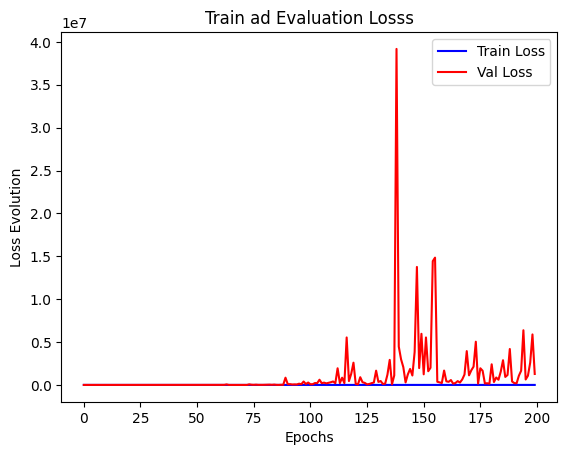

testing data:   0%|          | 0/2 [00:00<?, ?it/s]

MSE: tensor(21.6758, device='cuda:0')
RMSE: tensor(4.6557, device='cuda:0')
MAE: tensor(3.4683, device='cuda:0')
Spearman Corr: tensor(0.2450, device='cuda:0')


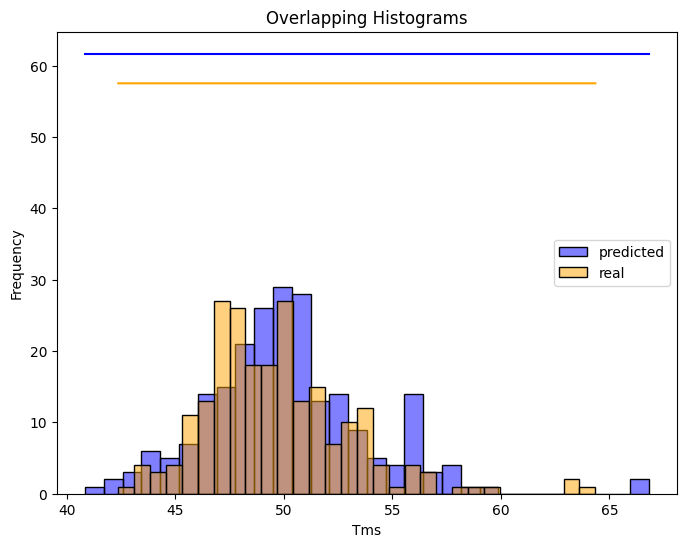

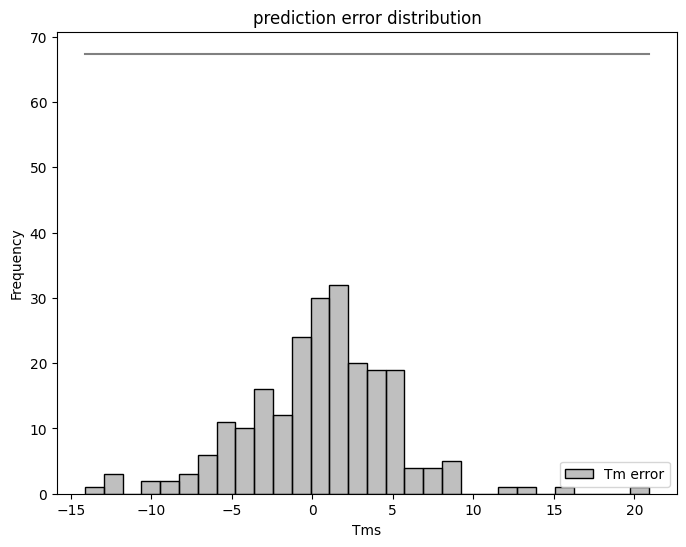

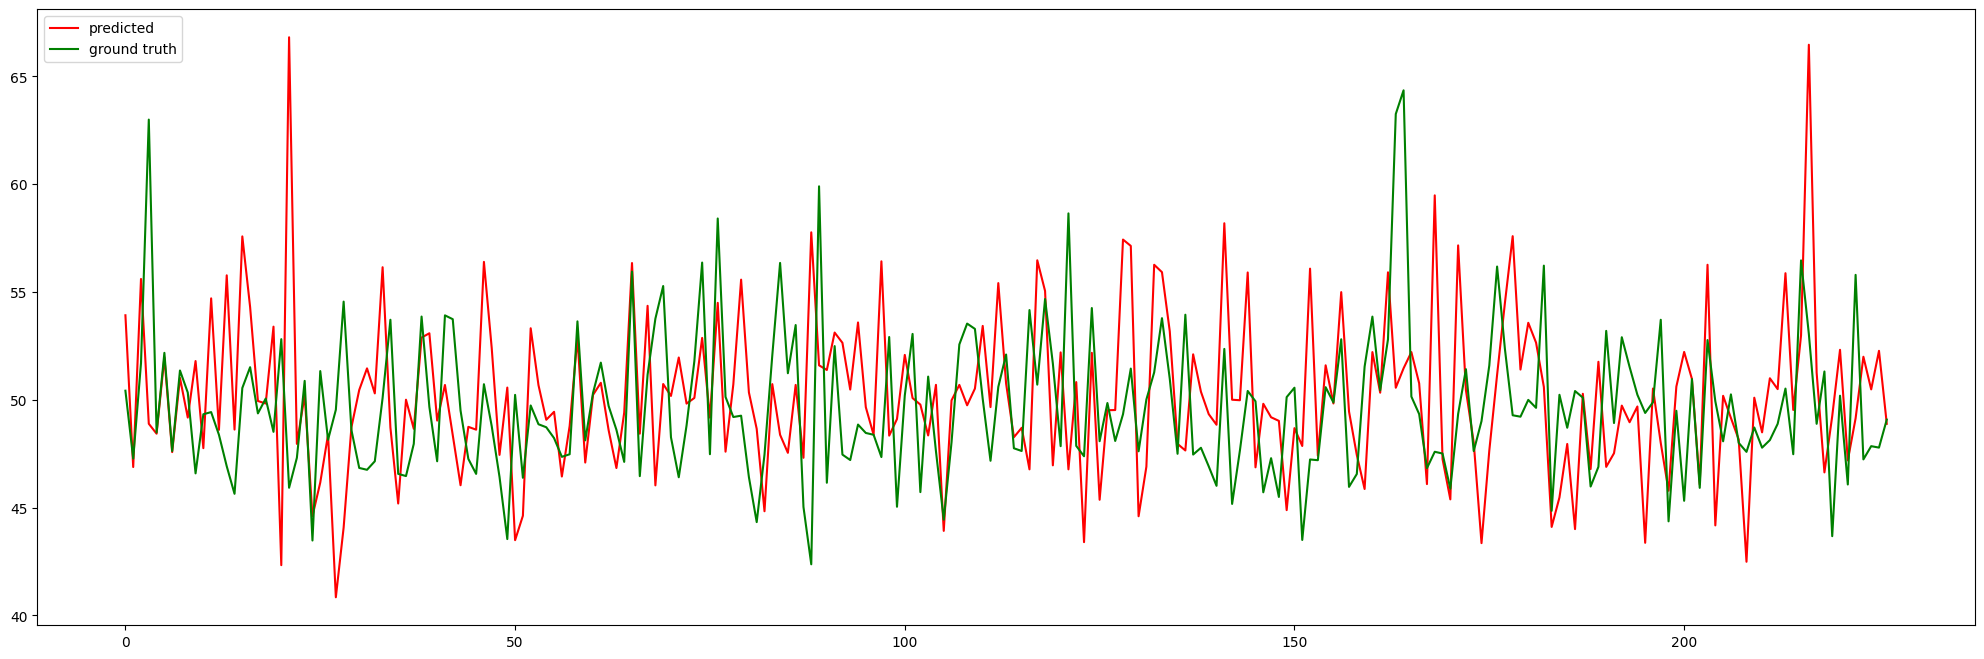

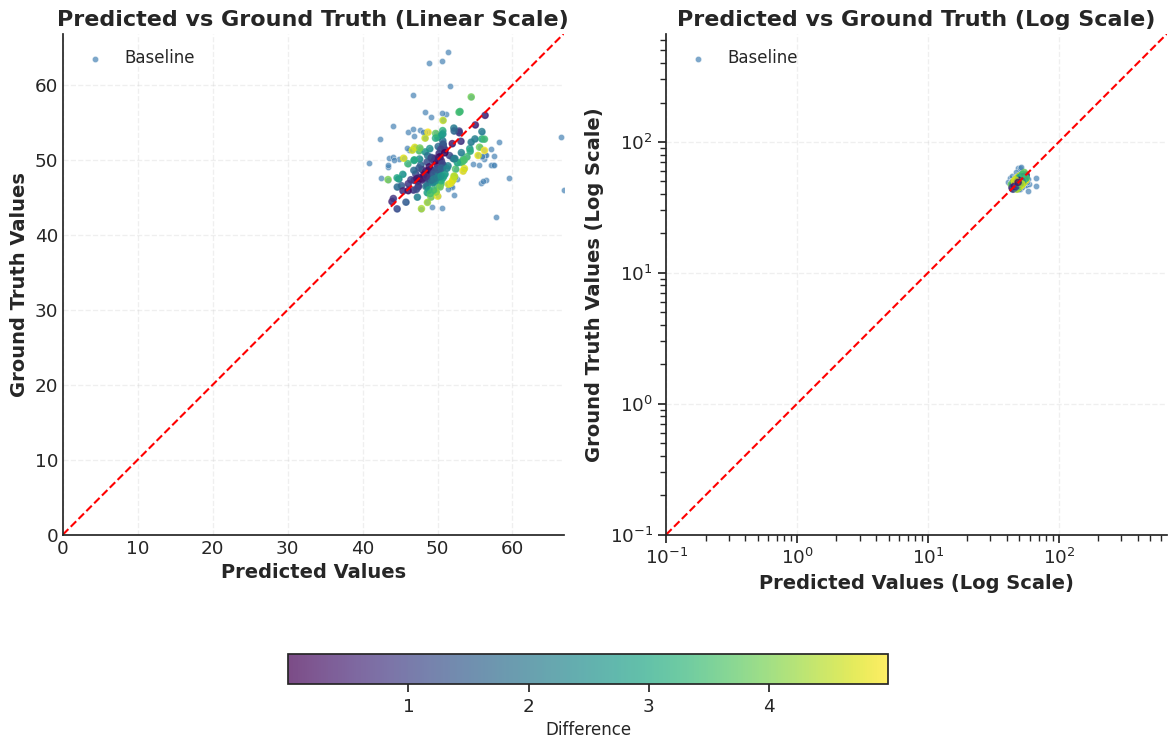

In [13]:

seq_struct_pred_W = LA_MLP_pred(embeddings_dim=1280, 
                                             output_dim=2, 
                                             dropout=0.25, 
                                             kernel_size=9, 
                                             conv_dropout= 0.25)
                                             #path_pretrained='../checkpoints/LA_MLP_TaskVectorBias_Merged_allnet_1_10_2023/')
# LightAttention(embeddings_dim=1280+128, output_dim=2, dropout=0.1, kernel_size=5, conv_dropout= 0.1)

optESM = torch.optim.AdamW(seq_struct_pred_W.parameters(), lr=1e-3)
lossESM= BiasOrganismLoss(device)#torch.nn.MSELoss()
epochs = 200

#import ipdb; ipdb.set_trace()
generating_results_approaches(seq_struct_pred_W, Trainer3, train_embedding_esm2, val_embedding_esm2, 
                              test_embedding_esm2, lossESM, optESM, epochs, device,
                              path_progres=path_progresESM, 
                              checkpoint_path=checkpoint_pathESM,
                              output_metrics=config['initial_paths']['output_metrics_ESM_only'])



### For Inverse Folding PiFold Using Prediction by Component (convolutions as a way of pooling + sum pooling to get the final predictions)

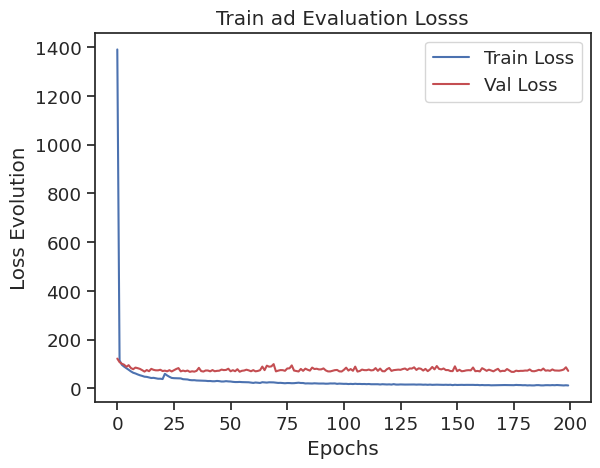

testing data:   0%|          | 0/2 [00:00<?, ?it/s]

MSE: tensor(20.8933, device='cuda:0')
RMSE: tensor(4.5709, device='cuda:0')
MAE: tensor(3.4943, device='cuda:0')
Spearman Corr: tensor(0.2249, device='cuda:0')


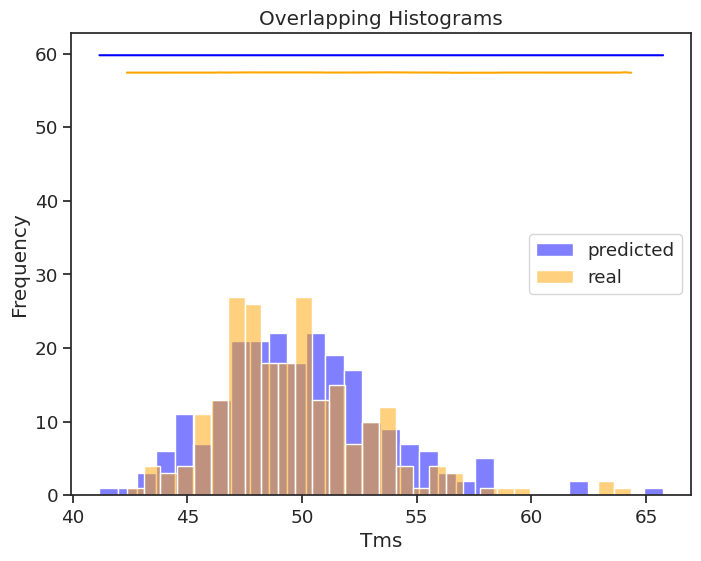

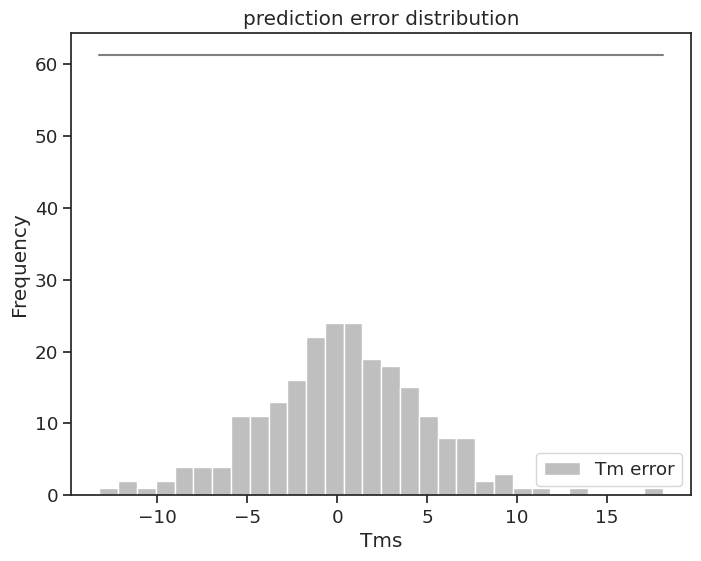

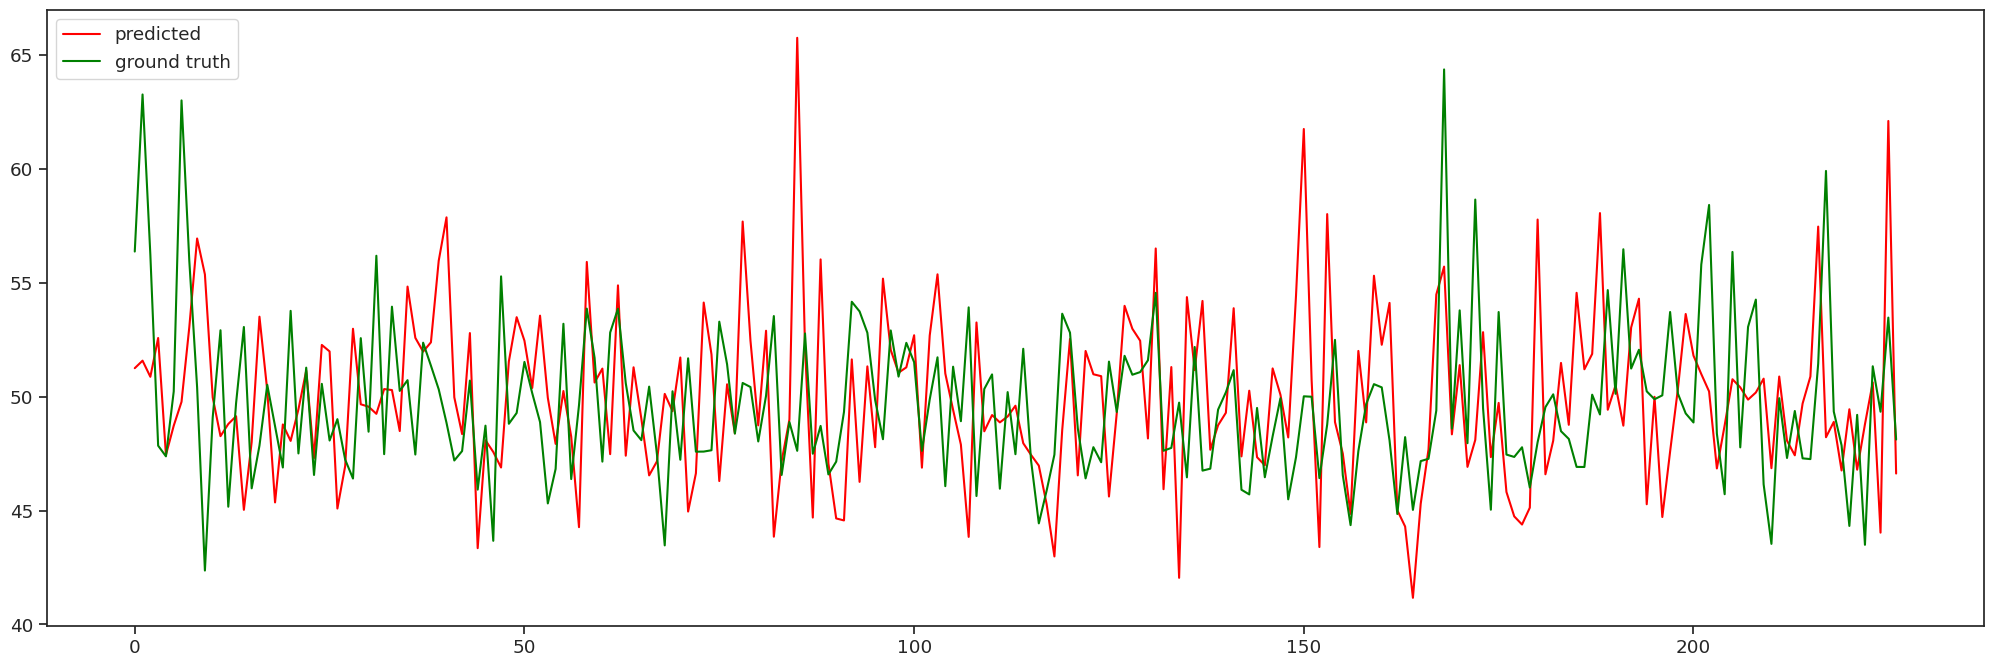

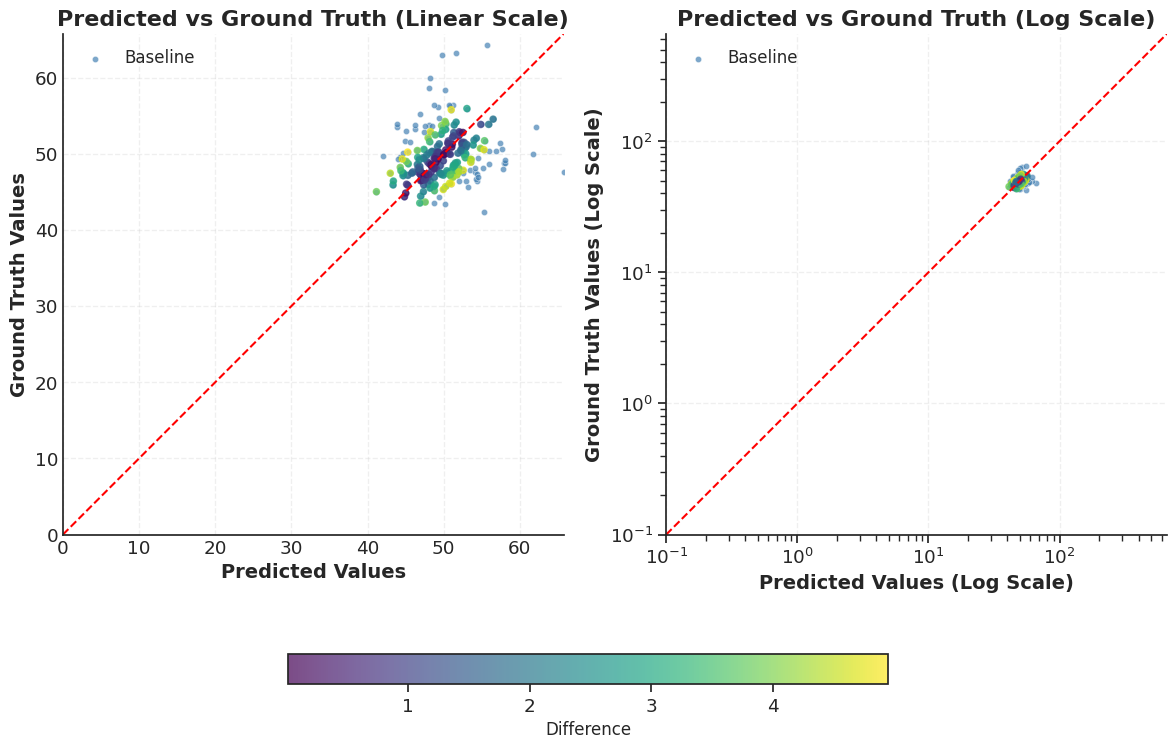

In [14]:

seq_struct_pred_W_PiFold = LA_MLP_pred(embeddings_dim=128, 
                                             output_dim=2, 
                                             dropout=0.25, 
                                             kernel_size=9, 
                                             conv_dropout= 0.25)
                                             #path_pretrained='../checkpoints/LA_MLP_TaskVectorBias_Merged_allnet_1_10_2023/')
# LightAttention(embeddings_dim=1280+128, output_dim=2, dropout=0.1, kernel_size=5, conv_dropout= 0.1)


optPiFold = torch.optim.AdamW(seq_struct_pred_W_PiFold.parameters(), lr=1e-3)
lossPiFold= BiasOrganismLoss(device)#torch.nn.MSELoss()
epochs = 200

generating_results_approaches(seq_struct_pred_W_PiFold, Trainer3, train_embedding_PiFold, val_embedding_PiFold, 
                              test_embedding_PiFold, lossPiFold, optPiFold, epochs, device,
                              path_progres=path_progresPiFold, 
                              checkpoint_path=checkpoint_pathPiFold,
                              output_metrics=config['initial_paths']['output_metrics_PiFold_only'])


### For Both ESM2 and Inverse Folding PiFold Contributions Together Using Prediction by Component (convolutions as a way of pooling + sum pooling to get the final predictions)

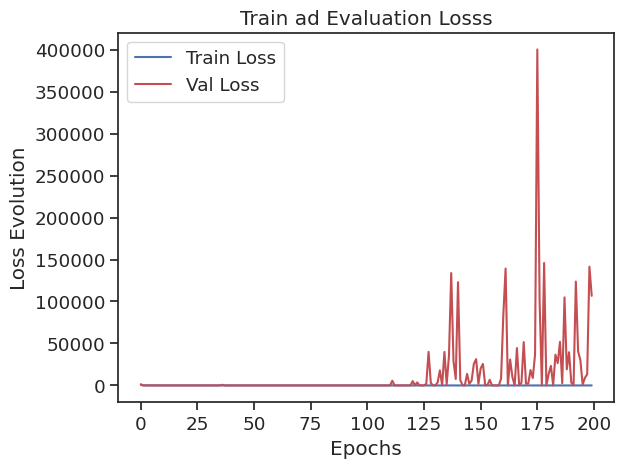

testing data:   0%|          | 0/2 [00:00<?, ?it/s]

MSE: tensor(16.9986, device='cuda:0')
RMSE: tensor(4.1229, device='cuda:0')
MAE: tensor(3.2280, device='cuda:0')
Spearman Corr: tensor(0.2870, device='cuda:0')


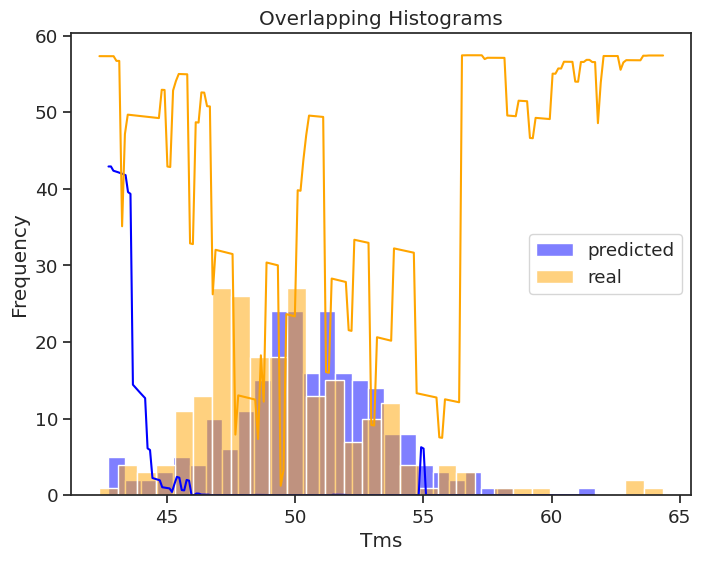

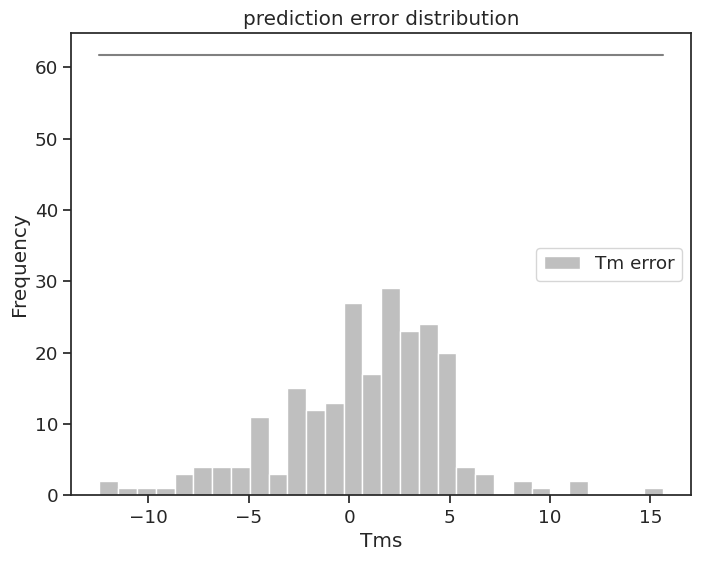

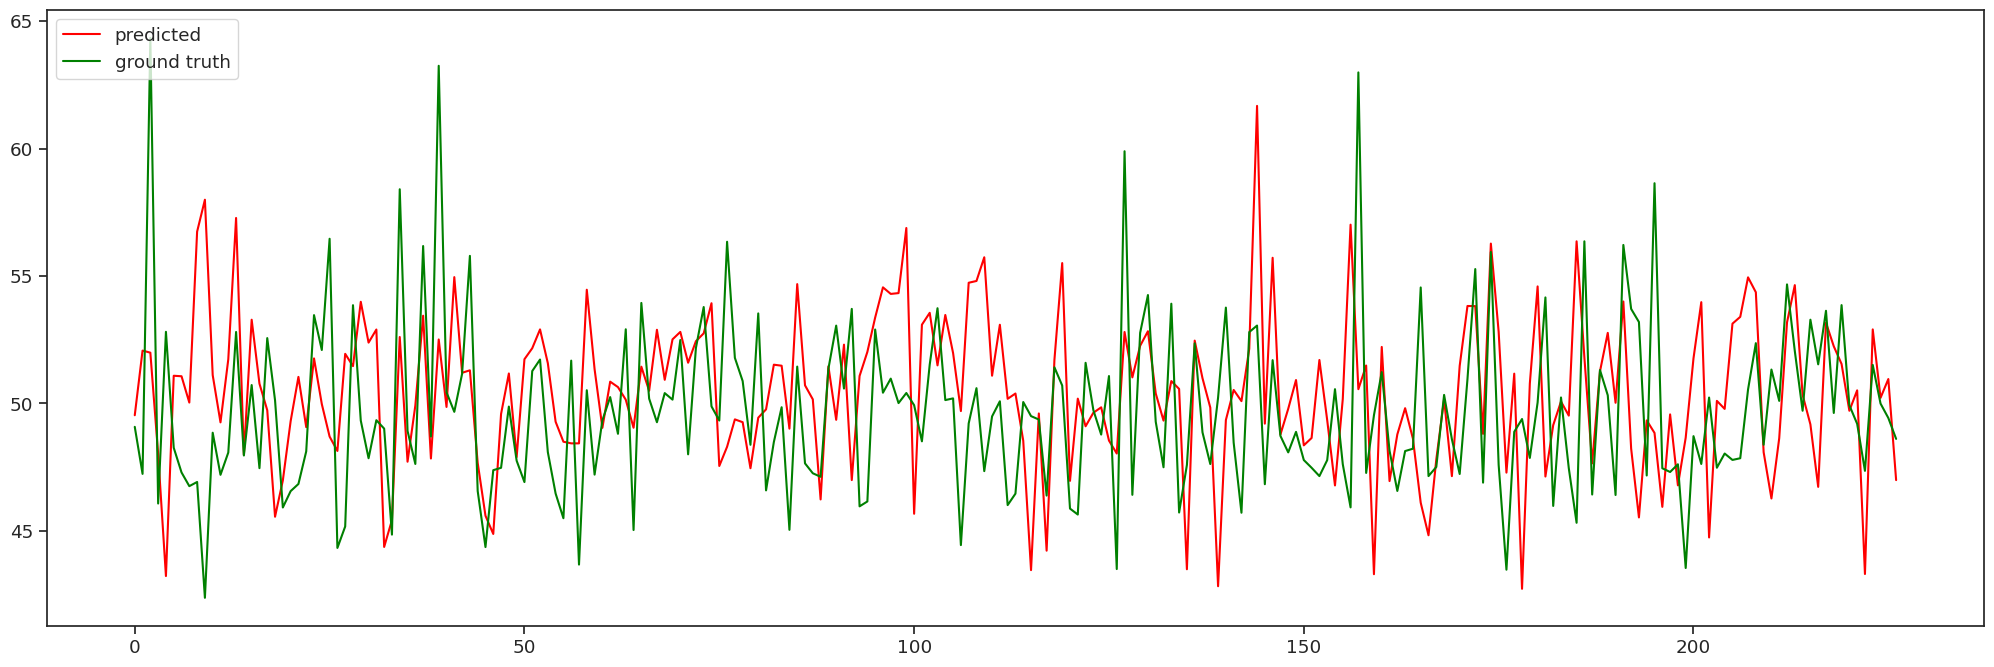

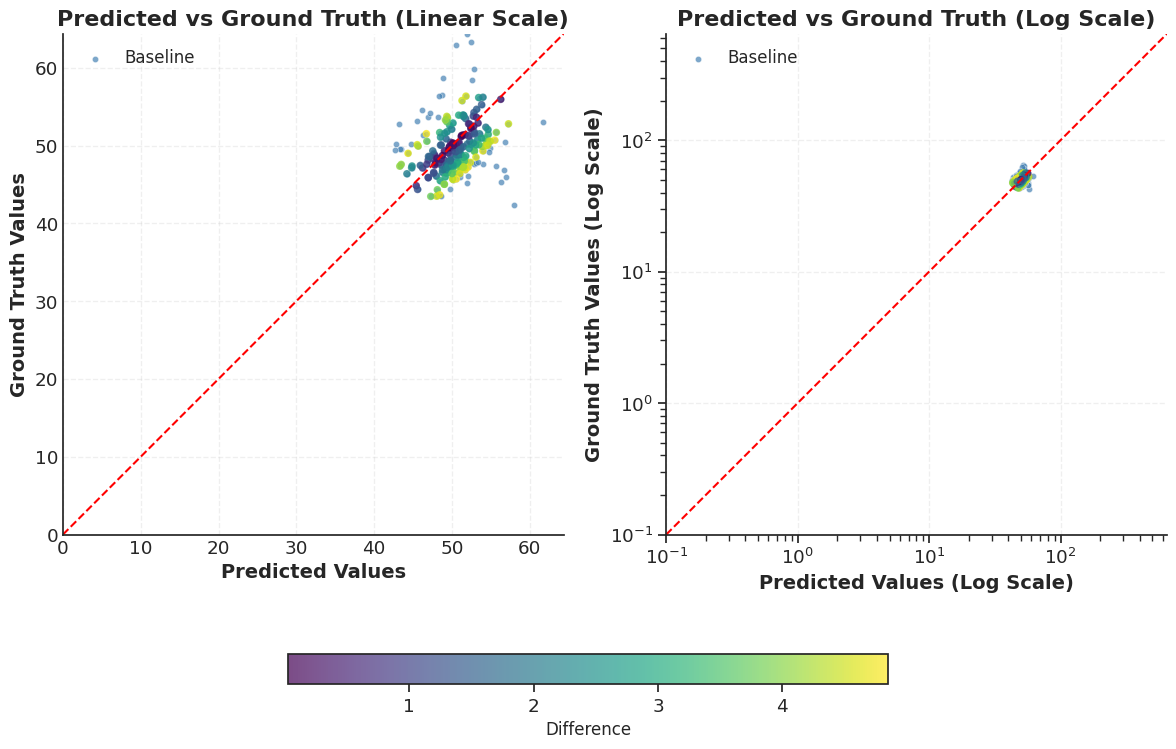

In [15]:

import torchsort, sys
sys.path.append(os.path.abspath("../ref_models/fast_soft_sort"))
from ref_models.fast_soft_sort.fast_soft_sort.pytorch_ops import soft_rank, soft_sort

#import ipdb; ipdb.set_trace()
seq_struct_pred_W_merged = LA_MLP_pred(embeddings_dim=1280+128, 
                                             output_dim=2, 
                                             dropout=0.25, 
                                             kernel_size=9, 
                                             conv_dropout= 0.25)
                                             #path_pretrained='../checkpoints/LA_MLP_TaskVectorBias_Merged_allnet_1_10_2023/')
# LightAttention(embeddings_dim=1280+128, output_dim=2, dropout=0.1, kernel_size=5, conv_dropout= 0.1)


optIFM = torch.optim.AdamW(seq_struct_pred_W_merged.parameters(), lr=1e-3)
lossIFM= BiasOrganismLoss(device)#torch.nn.MSELoss()
epochs = 200

#import ipdb; ipdb.set_trace()
generating_results_approaches(seq_struct_pred_W_merged, Trainer3, train_embedding_merged, val_embedding_merged, 
                              test_embedding_merged, lossIFM, optIFM, epochs, device,
                              path_progres=path_progresMix, 
                              checkpoint_path=checkpoint_pathMix,
                              output_metrics=config['initial_paths']['output_metrics_Both'])
